# NYSE FANG+ index 日足 メディアン統計

In [16]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [17]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'NYFANG'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-20 00:00:00-04:00,9888.299805,10076.639648,9882.799805,10064.070312,0,0.0,0.0
2024-03-21 00:00:00-04:00,10064.070312,10207.280273,10040.320312,10043.469727,0,0.0,0.0
2024-03-22 00:00:00-04:00,10043.469727,10137.169922,10006.709961,10113.120117,0,0.0,0.0
2024-03-25 00:00:00-04:00,10113.120117,10124.799805,10026.709961,10088.129883,0,0.0,0.0
2024-03-26 00:00:00-04:00,10088.129883,10195.070312,10047.690430,10050.230469,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-13 00:00:00-04:00,12009.730469,12009.730469,11637.799805,11680.030273,0,0.0,0.0
2025-03-14 00:00:00-04:00,11680.030273,12073.919922,11680.030273,12057.169922,0,0.0,0.0
2025-03-17 00:00:00-04:00,12057.169922,12209.969727,11998.240234,12092.110352,0,0.0,0.0


In [18]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-21 00:00:00-04:00,6434.229980,6460.120117,6278.669922,6392.700195,0,0.0,0.0
2022-03-22 00:00:00-04:00,6392.700195,6653.000000,6392.700195,6625.990234,0,0.0,0.0
2022-03-23 00:00:00-04:00,6625.990234,6720.390137,6527.649902,6581.189941,0,0.0,0.0
2022-03-24 00:00:00-04:00,6581.189941,6684.959961,6499.680176,6683.759766,0,0.0,0.0
2022-03-25 00:00:00-04:00,6683.759766,6683.759766,6545.899902,6650.040039,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-13 00:00:00-04:00,12009.730469,12009.730469,11637.799805,11680.030273,0,0.0,0.0
2025-03-14 00:00:00-04:00,11680.030273,12073.919922,11680.030273,12057.169922,0,0.0,0.0
2025-03-17 00:00:00-04:00,12057.169922,12209.969727,11998.240234,12092.110352,0,0.0,0.0


## Moving Median

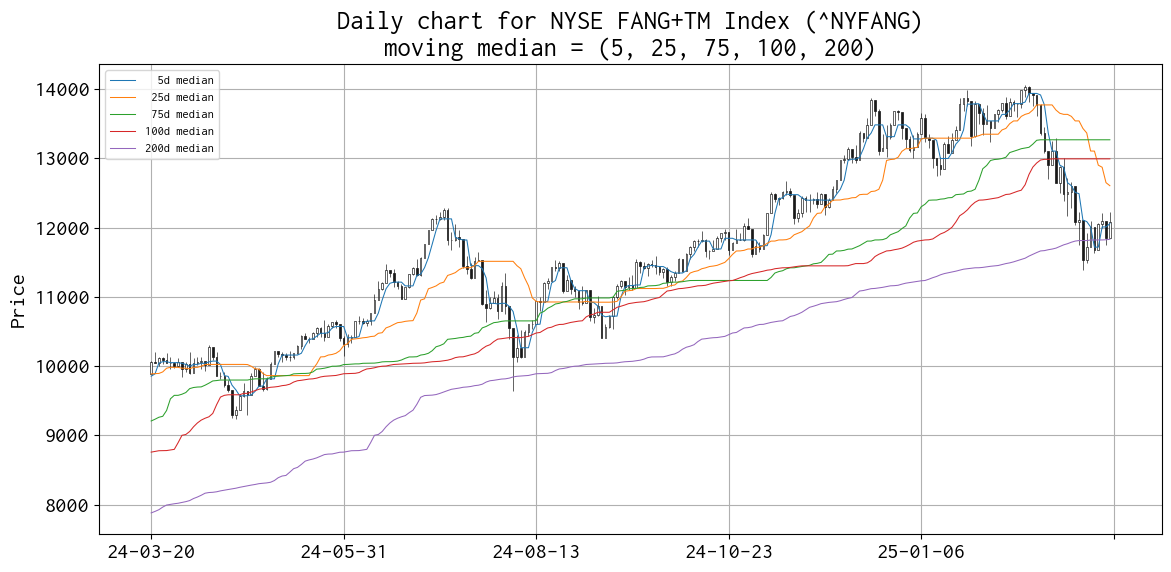

In [19]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
ax.set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [20]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-18 00:00:00-04:00,12092.110352,12092.110352,11750.429688,11850.049805,0,0.0,0.0
2025-03-19 00:00:00-04:00,11850.099609,12225.123047,11844.941406,12085.932617,0,0.0,0.0


In [21]:
df.tail(2)['Close']

Date
2025-03-18 00:00:00-04:00    11850.049805
2025-03-19 00:00:00-04:00    12085.932617
Name: Close, dtype: float64

In [22]:
df.tail(2)['Close'].diff()

Date
2025-03-18 00:00:00-04:00           NaN
2025-03-19 00:00:00-04:00    235.882812
Name: Close, dtype: float64

In [23]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-19 00:00:00-04:00    235.833008
dtype: float64

In [24]:
df['Close'].rolling(9).median().tail()

Date
2025-03-13 00:00:00-04:00    12087.469727
2025-03-14 00:00:00-04:00    12057.169922
2025-03-17 00:00:00-04:00    12057.169922
2025-03-18 00:00:00-04:00    12009.730469
2025-03-19 00:00:00-04:00    12009.730469
Name: Close, dtype: float64

In [25]:
df['Close'].rolling(13).median().tail()

Date
2025-03-13 00:00:00-04:00    12490.400391
2025-03-14 00:00:00-04:00    12109.650391
2025-03-17 00:00:00-04:00    12092.110352
2025-03-18 00:00:00-04:00    12087.469727
2025-03-19 00:00:00-04:00    12085.932617
Name: Close, dtype: float64

In [26]:
df['Close'].rolling(26).median().tail()

Date
2025-03-13 00:00:00-04:00    13105.719727
2025-03-14 00:00:00-04:00    13003.369629
2025-03-17 00:00:00-04:00    12886.839844
2025-03-18 00:00:00-04:00    12760.595215
2025-03-19 00:00:00-04:00    12627.370117
Name: Close, dtype: float64

In [27]:
df['Close'].rolling(52).median().tail()

Date
2025-03-13 00:00:00-04:00    13338.375000
2025-03-14 00:00:00-04:00    13309.865234
2025-03-17 00:00:00-04:00    13286.464844
2025-03-18 00:00:00-04:00    13280.180176
2025-03-19 00:00:00-04:00    13280.180176
Name: Close, dtype: float64

## Robust Bollinger's bands

In [28]:
period = 20
calc_robust_bollinger(df0, period)
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Median,Q1,Q3,Lower,Upper
Date,,,,,,,,,,,,
2022-03-21 00:00:00-04:00,6434.229980,6460.120117,6278.669922,6392.700195,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-22 00:00:00-04:00,6392.700195,6653.000000,6392.700195,6625.990234,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-23 00:00:00-04:00,6625.990234,6720.390137,6527.649902,6581.189941,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-24 00:00:00-04:00,6581.189941,6684.959961,6499.680176,6683.759766,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-03-25 00:00:00-04:00,6683.759766,6683.759766,6545.899902,6650.040039,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13 00:00:00-04:00,12009.730469,12009.730469,11637.799805,11680.030273,0,0.0,0.0,12886.839844,12395.212891,13774.204834,10326.724976,15842.692749
2025-03-14 00:00:00-04:00,11680.030273,12073.919922,11680.030273,12057.169922,0,0.0,0.0,12760.595215,12104.105225,13468.057129,10058.177368,15513.984985
2025-03-17 00:00:00-04:00,12057.169922,12209.969727,11998.240234,12092.110352,0,0.0,0.0,12627.370117,12079.894775,13171.544678,10442.419922,14809.019531


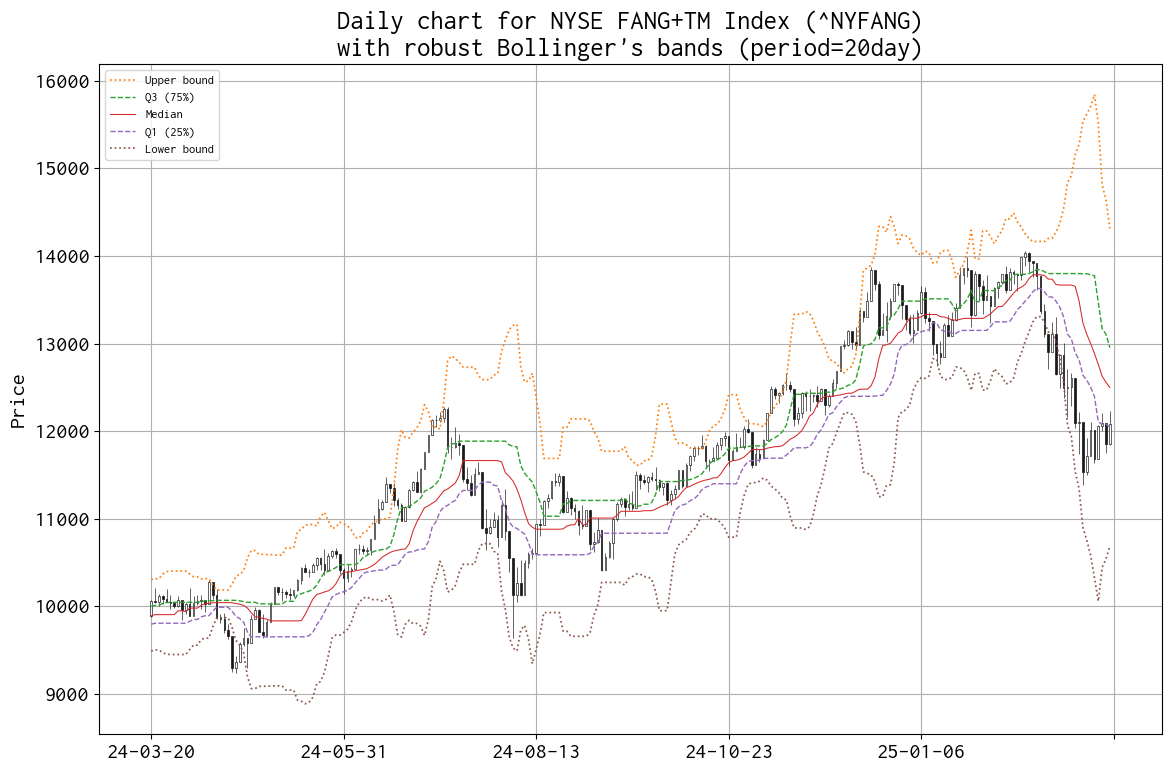

In [29]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
mv_median = df0['Median']
mv_q1 = df0['Q1']
mv_q3 = df0['Q3']
mv_lower = df0['Lower']
mv_upper = df0['Upper']

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger\'s bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger\'s bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

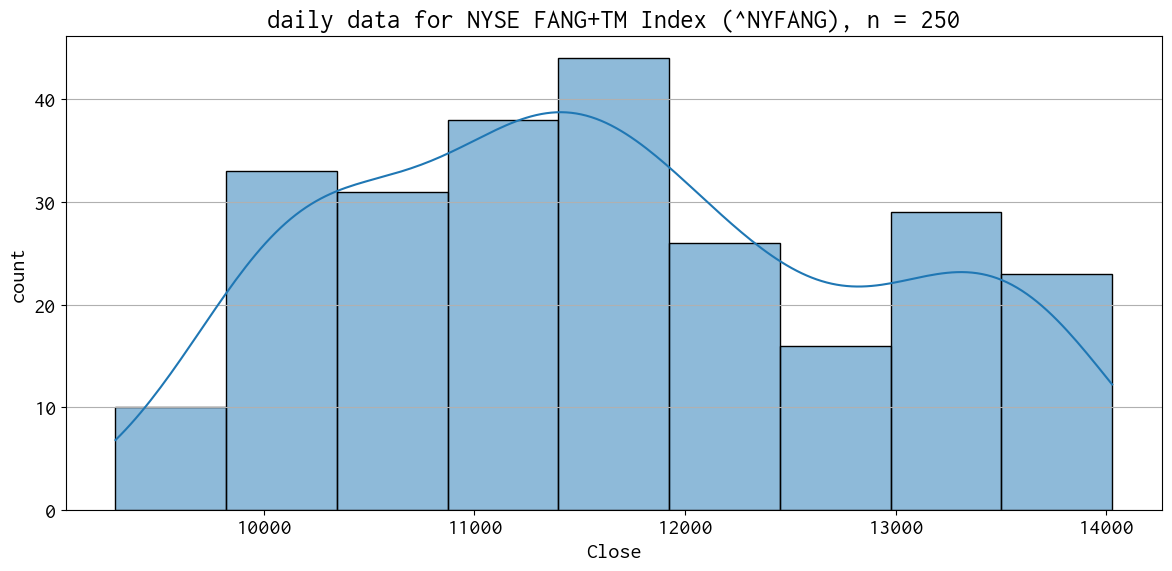

In [30]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 6))
#ax = fig.add_axes(111)
ax = fig.add_subplot(111)

sns.histplot(
    df['Close'],
    kde=True,
    ax=ax
)

ax.set_xlabel("Close")
ax.set_ylabel("count")
ax.set_title('daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)))
ax.grid(axis = 'y')

plt.tight_layout()
plt.savefig('report_daily_histogram_%s.png' % code)
plt.show()